# Look at Laser data 

Laser vibrometry studies using fingerprints


In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp
import platform

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle for collors and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)

In [2]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [3]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [4]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Laser Data/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\SubSet\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [5]:
print(Computer, folder, rootfolder)

SciClone /sciclone/scr10/dchendrickson01/Laser Data/ /sciclone/home20/dchendrickson01/


In [6]:
#Extra Headers:
import os as os
import statistics as st
import random
#import multiprocessing
#from joblib import Parallel, delayed
import time
import CoreFunctions as cf
import DWFT as df
import pywt
import scipy.signal as signal
from matplotlib import ticker

my_cmap = plt.get_cmap('gray')

import warnings
warnings.simplefilter('ignore', np.RankWarning)


In [7]:
# Directory = './Data'
#Directory = 'C:\\Users\\Dan\\Desktop\\Temp\\'
#Directory = 'C:\\Users\\dhendrickson\\Desktop\\AccelData\\home\\pi\\AccelData\\'
files = os.listdir(folder)

In [8]:
wvlt = 'db3'

In [9]:
f2 = []
for file in files:
    if file[:8] == 'stack 27' or file[:8] =='Stack 27':
        f2.append(file)


In [10]:
good = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,23,26,29,30,31]

## Functions for visual search


In [11]:
def focusArea(f, start, end, graph=True):
    file = f2[f]
    ODataSet = np.genfromtxt(open(folder+'/'+file,'r'), delimiter=',',skip_header=1)
    ODataSet = ODataSet[:,2:5]
    for coord in range(2):
        for j in range(np.shape(ODataSet)[0]-1):
            try:
                ODataSet[j,coord] = float(ODataSet[j,coord])
            except:
                ODataSet[j,coord] = ODataSet[j-1,coord]
            if ODataSet[j,coord] == -999.999:
                ODataSet[j,coord] = ODataSet[j-1,coord]

    Diffs = np.zeros(np.shape(ODataSet)[0])
    for j in range(np.shape(ODataSet)[0]-1):
        Diffs[j] = ODataSet[j,0] - ODataSet[j,1]
    norm = np.average(ODataSet[:,0])
    ODataSet[:,0]-=norm
    norm = np.average(ODataSet[:,1])
    ODataSet[:,1]-=norm
    norm = np.average(Diffs)
    Diffs[:]-=norm
    Cdiff = cf.Smoothing(Diffs,2,dets_to_remove=3)
    
    if end > len(Cdiff):
        end = len(Cdiff)
    
    if graph:
        fig,axs = plt.subplots(2,figsize=(6,4), dpi=600)
        plt.subplots_adjust(hspace=0.5)
        plt.title(str(f)+' ' + file)
        axs[0].plot(Cdiff[25:-50], linewidth=0.5)
        axs[1].plot(np.linspace(start,end,end-start),Cdiff[start:end]-np.average(Cdiff[start:end]), linewidth=0.5)
        plt.show()
    
    return Cdiff

In [12]:
def focusRanges(CDiff, start, scales=50):
    fig,axs = plt.subplots(5,figsize=(6,3), dpi=1200)
    plt.subplots_adjust(hspace=0.5)
    Y = np.arange(0,scales)

    for j in range(5):
        i=j-1
        starts = start + i*1000
        ends = starts + 3000
        NData = CDiff[starts:ends]
        
        NData -= np.average(NData)
        newFP = cf.getThumbprint2(NData, wvlt, scales,1)
        X = np.arange(starts+1000,ends-1000,dtype=int)
        axs[j].contourf(X,Y,newFP[1000:2000].T, cmap='gist_gray')
    #    axs[j].xaxis.set_ticks(X)
        axs[j].set_xticklabels(axs[j].get_xticks(),fontsize=5)
        axs[j].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        axs[j].set_yticklabels(axs[j].get_yticks(),fontsize=5)
        axs[j].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        #plt.title(str(start))
    plt.show()




In [13]:
def fineFocus(CDiff, start, gap):
    starts = start-1000
    START = gap

    ends = starts + 4000
    
    NData = Cdiff[starts:ends]
    
    NData -= np.average(NData)
    newFP = cf.getThumbprint2(NData, wvlt, 50,1)
    X = np.arange(starts+START+1000,starts+START+1250)
    Y = np.arange(0,50)
    fig = plt.figure(figsize=(10,3), dpi=600)
    plt.contourf(X,Y,newFP[START+1000:START+1250].T, cmap='gist_gray')
    #plt.title(str(start))
    plt.show()


In [14]:
start = 400000
end = 450000

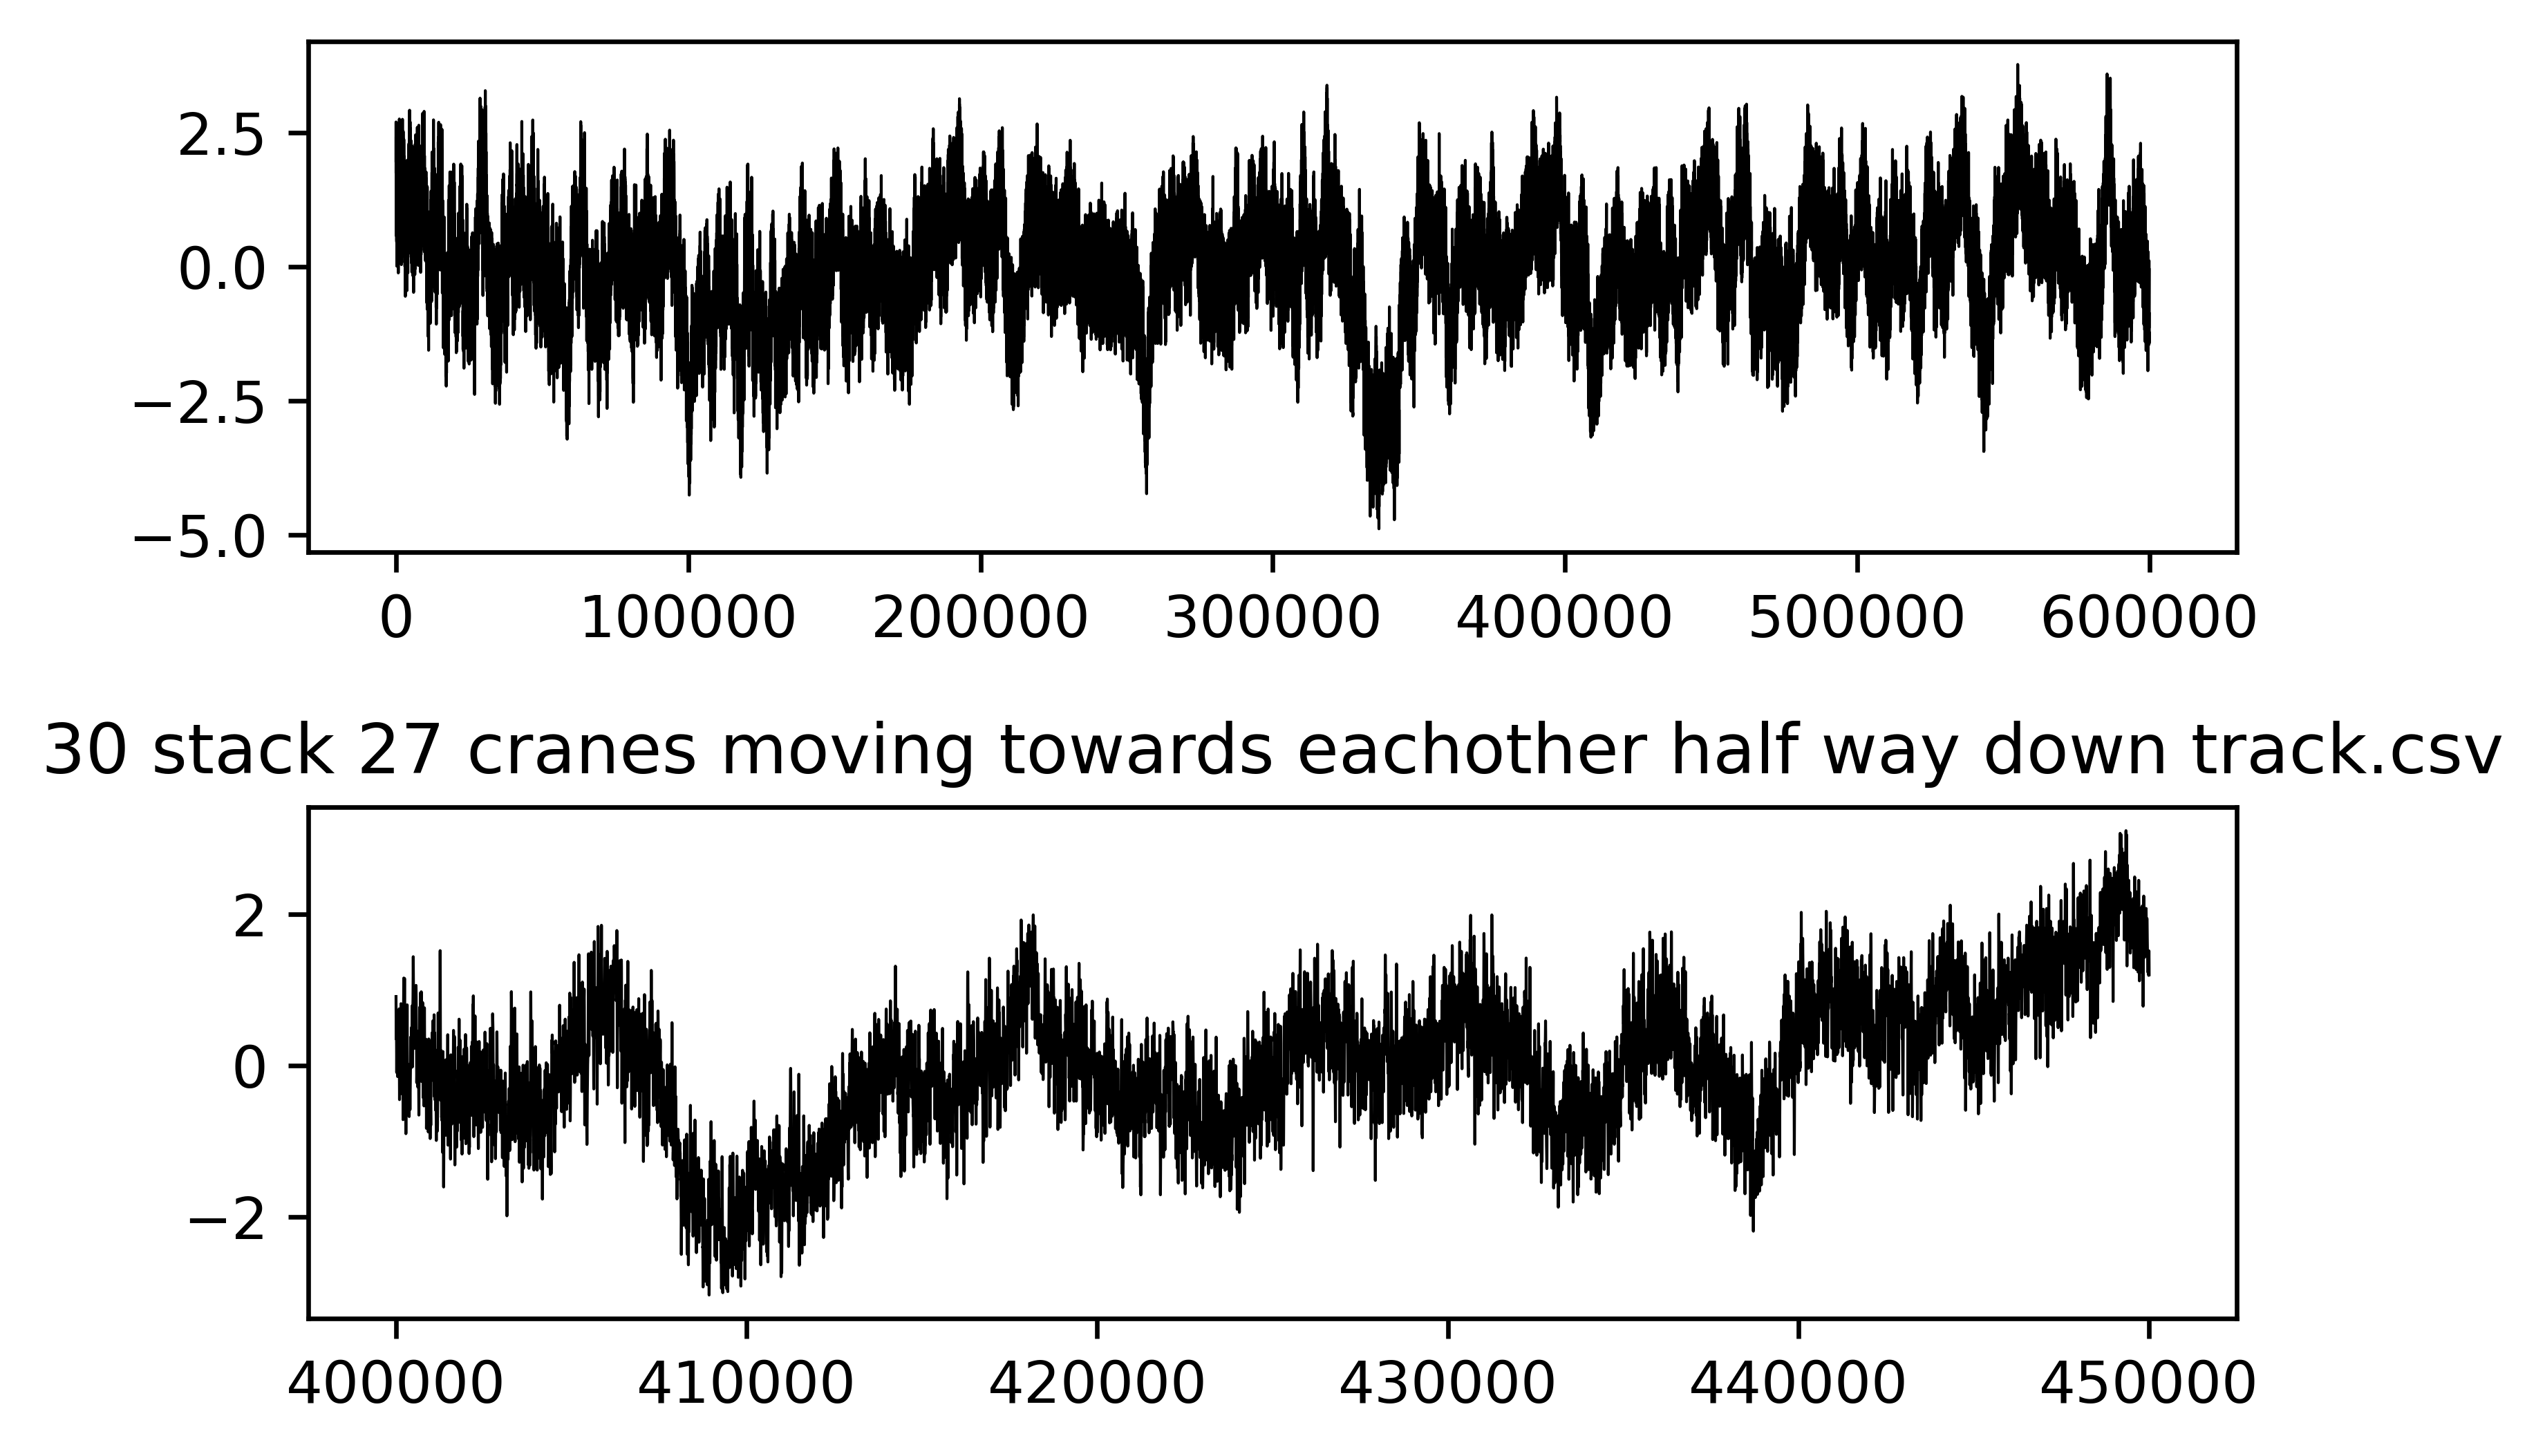

In [15]:
Cdiff = focusArea(30,start,end)

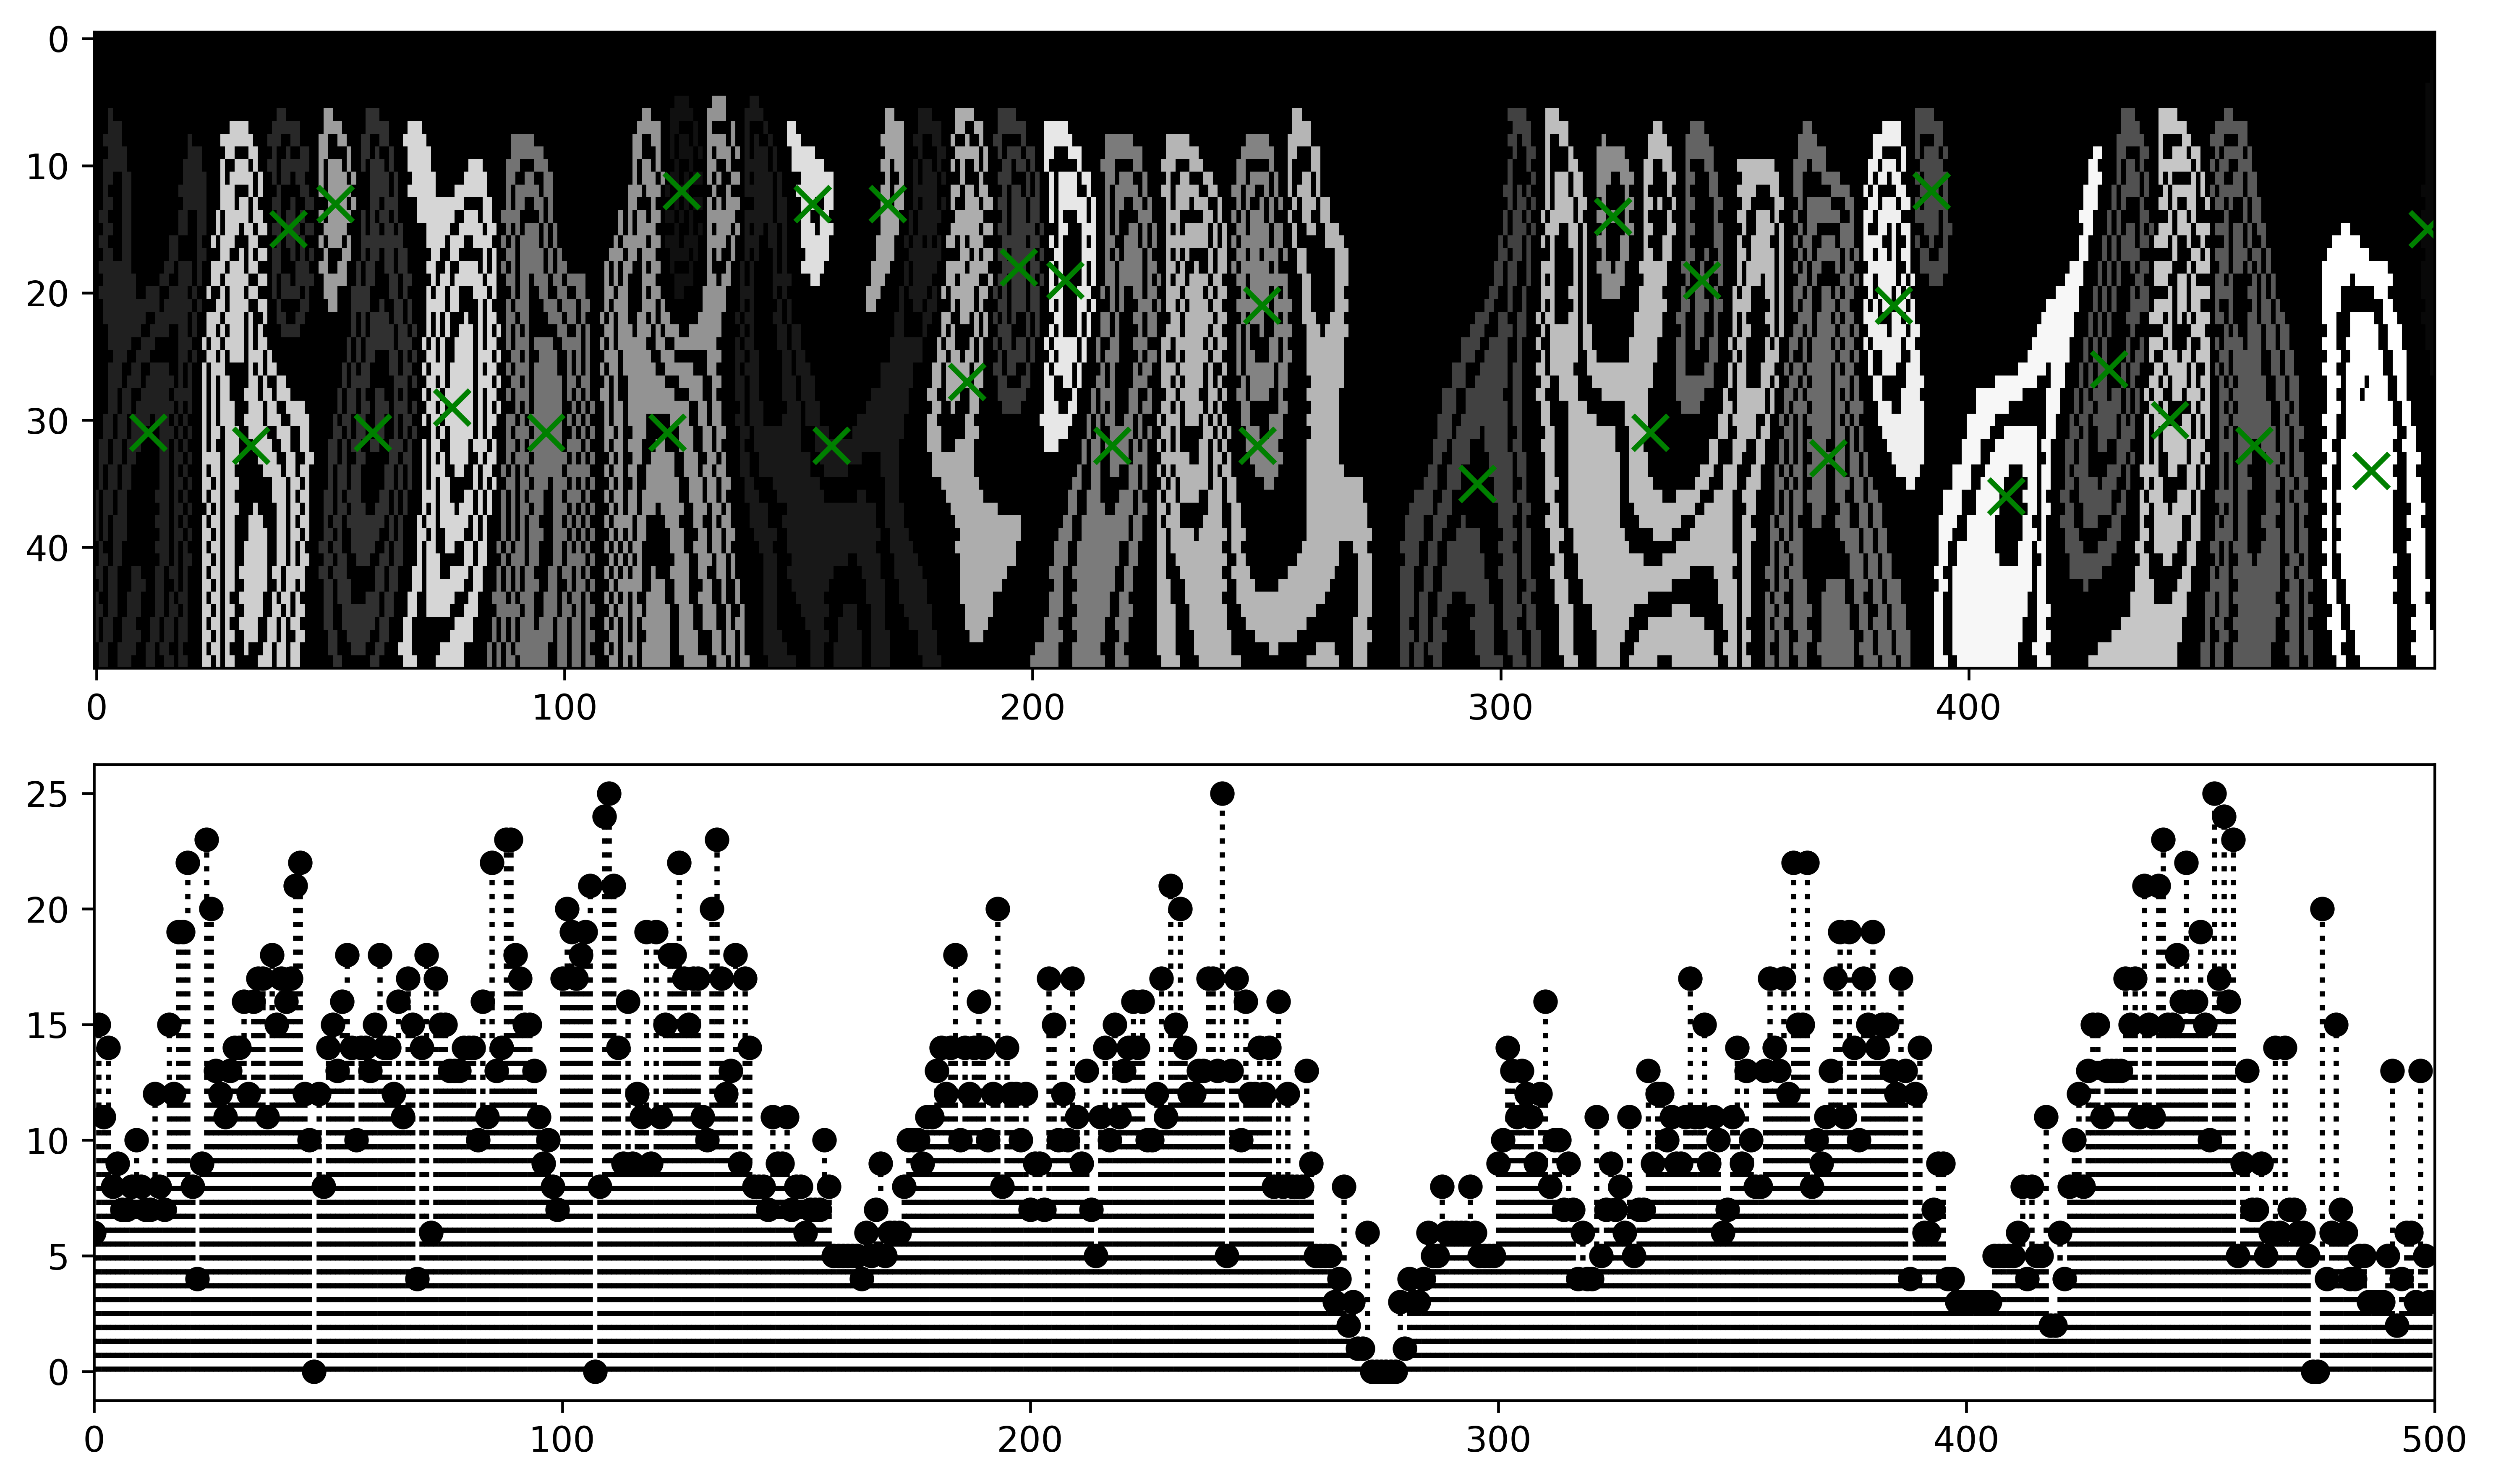

In [16]:
test, fbcom = df.getProcessedFP(Cdiff[226200:226700],'db3', graph=True)

In [17]:
fbcom.shape

(32, 2)

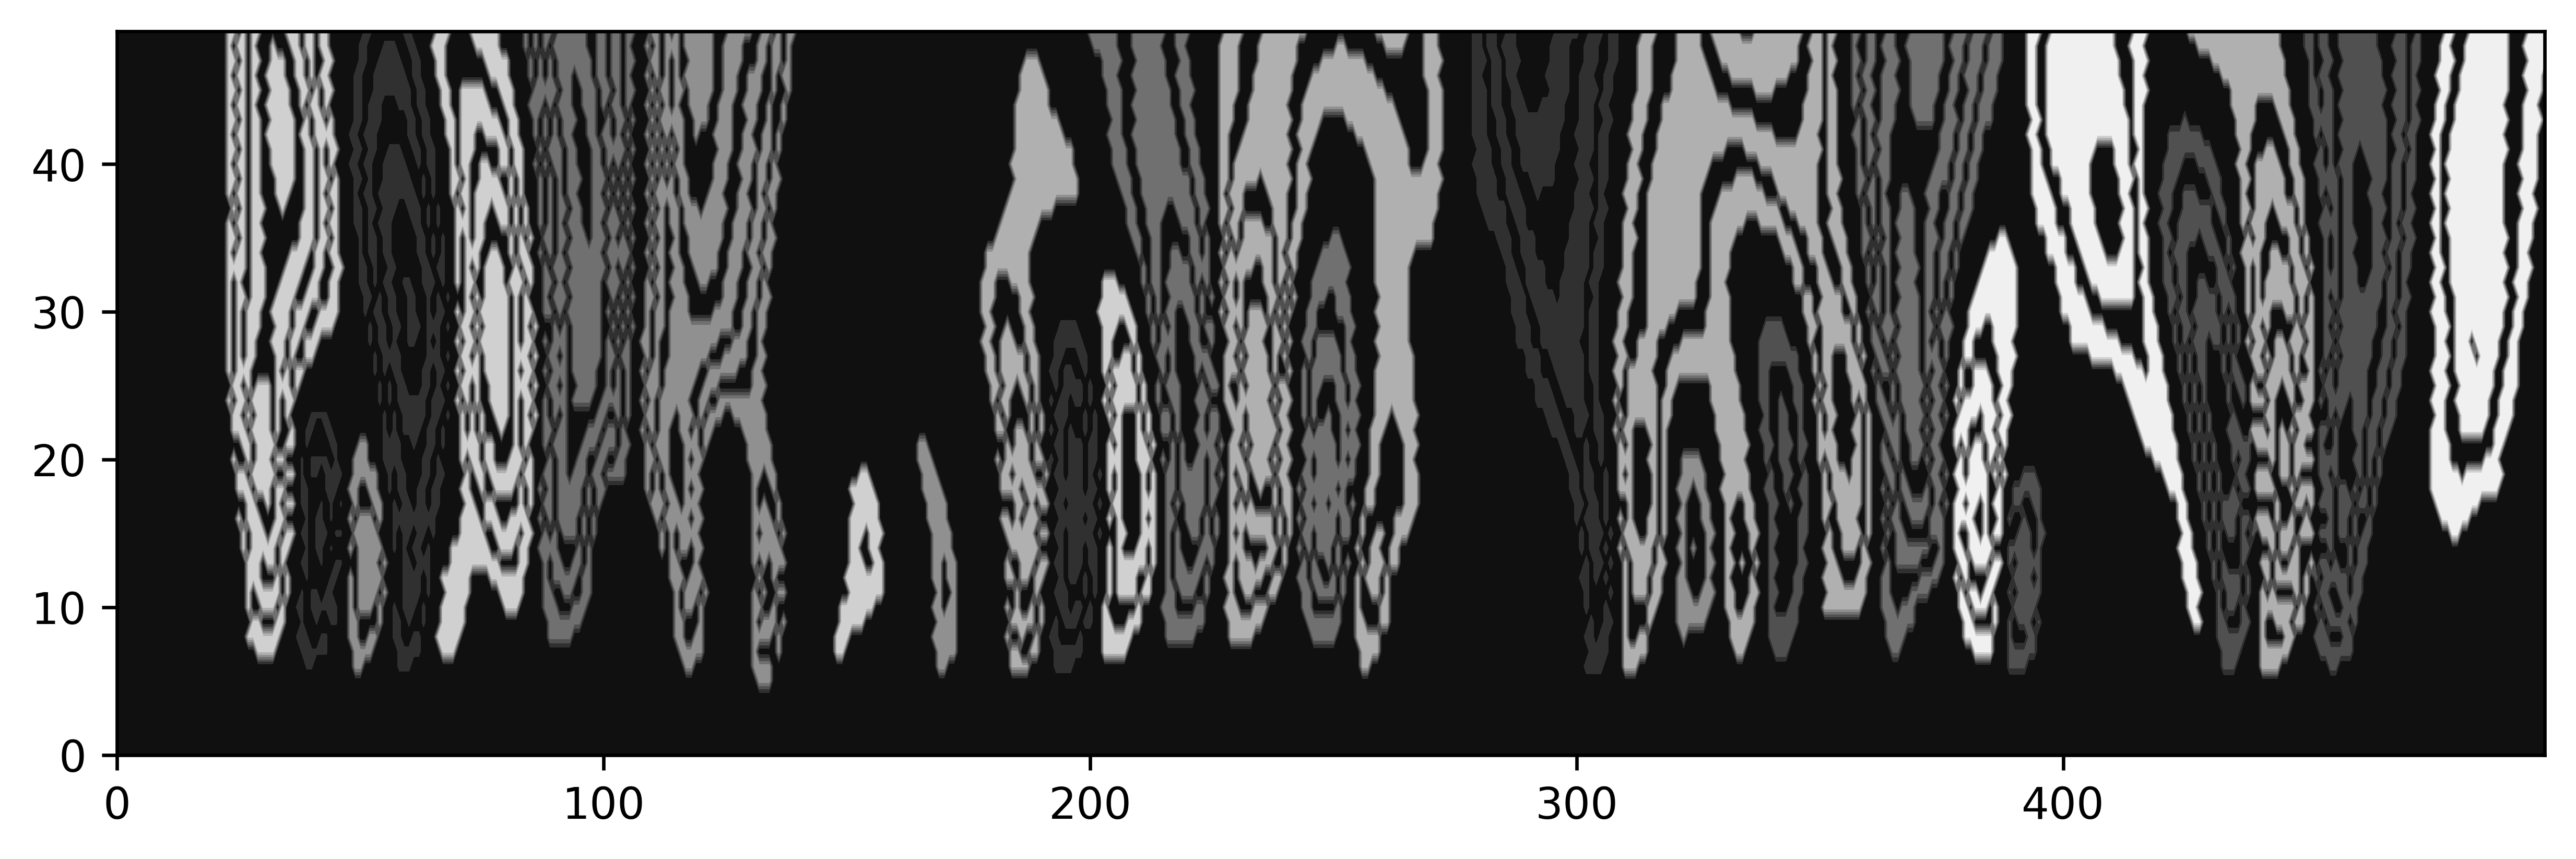

In [18]:
fig = plt.figure(figsize=(10,3), dpi=600)
plt.contourf(test, cmap='gist_gray')
#plt.title(str(start))
plt.show()

In [19]:
Vect=[]


for i in range(fbcom.shape[0]):
    Vect.append(df.FPFeatureVector(test,i)[0])
    

In [20]:
mVect = np.matrix(Vect)

In [21]:
np.savetxt("FV.csv",mVect,delimiter=",")

In [22]:
fpCount = 0
FullMatrix = np.zeros((1,28))
fpRange = 1000
Loops = int(Cdiff.shape[0]/fpRange)

In [23]:
ti = time.time()

In [24]:
for i in range(Loops):
    Vect=[]
    test, fbcom = df.getProcessedFP(Cdiff[i*fpRange:(i+1)*fpRange],'db3')
    
    for j in range(fbcom.shape[0]):
        Vect.append(df.FPFeatureVector(test,j)[0])
    
    Vect=np.matrix(Vect) 
    fbcom=np.matrix(fbcom)
    fbcom=np.concatenate((fbcom,np.matrix(np.arange(fpCount,fpCount+fbcom.shape[0])).T),axis=1)
    #fbcom=fbcom.reshape(fbcom.shape[0],fbcom.shape[2])
    
    fpCount+=fbcom.shape[0]
    
    CombiData = np.concatenate((fbcom,Vect),axis=1)
    
    FullMatrix=np.concatenate((FullMatrix,CombiData),axis=0)
    
    if i%60 == 0:
        print(i, (time.time()-ti)/60)

0 0.2243572433789571
60 12.87996774117152
120 25.692687940597533
180 38.39827216068904
240 51.1353829185168
300 63.76980324983597
360 75.78856505552928


/sciclone/home/dchendrickson01/.conda/envs/torchmpi/lib/python3.11/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale



Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
420 86.66516062021256
480 97.44018258651097
540 108.33778227567673


In [25]:
for i in range(len(Vect)):
    print(len(Vect[i]))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [26]:
asdfasdf

NameError: name 'asdfasdf' is not defined

In [ ]:
fbcom.shape

In [ ]:
i=1
Vect=[]
test, fbcom = df.getProcessedFP(Cdiff[i*fpRange:(i+1)*fpRange],'db3')

for j in range(fbcom.shape[0]):
    Vect.append(df.FPFeatureVector(test,j)[0])

Vect=np.matrix(Vect) 
fbcom=np.matrix(fbcom)
fbcom=np.concatenate((fbcom,np.matrix(np.arange(fpCount,fpCount+fbcom.shape[0])).T),axis=1)
fbcom=fbcom.reshape(fbcom.shape[0],fbcom.shape[2])

fpCount+=fbcom.shape[0]

CombiData = np.concatenate((fbcom2,Vect),axis=1)

FullMatrix=np.concatenate((FullMatrix,CombiData),axis=0)

In [28]:
np.savetxt("FV.csv",FullMatrix,delimiter=",",fmt='%s')